In [1]:
import sys
import pickle
import numpy as np
import pandas as pd
import itertools
from collections import defaultdict
from tqdm.notebook import tqdm
sys.path.append('../../../scripts/')
from utils import *
from config import *

from matplotlib import rcParams
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
#rcParams.update(fig_params)

from scipy import stats as stats
from scipy.stats import rv_continuous, rv_histogram, norm, beta, multivariate_normal
from sklearn.model_selection import train_test_split
from scipy.linalg import block_diag

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

%load_ext autoreload
%autoreload 2

## Load data

In [27]:
with open('../../../data/comb.pickle', 'rb') as handle:
    data = pickle.load(handle)

df, metadata, features, target, rows = data.values()

In [31]:
df[features].columns[:100]

Index(['AATS0Z', 'AATS0are', 'AATS0d', 'AATS0dv', 'AATS0i', 'AATS0m', 'AATS0p',
       'AATS0pe', 'AATS0s', 'AATS0se', 'AATS0v', 'AATS1Z', 'AATS1are',
       'AATS1d', 'AATS1dv', 'AATS1i', 'AATS1m', 'AATS1p', 'AATS1pe', 'AATS1s',
       'AATS1se', 'AATS1v', 'AATS2Z', 'AATS2are', 'AATS2d', 'AATS2dv',
       'AATS2i', 'AATS2m', 'AATS2p', 'AATS2pe', 'AATS2s', 'AATS2se', 'AATS2v',
       'AATS3Z', 'AATS3are', 'AATS3d', 'AATS3dv', 'AATS3i', 'AATS3m', 'AATS3p',
       'AATS3pe', 'AATS3s', 'AATS3se', 'AATS3v', 'AATS4Z', 'AATS4are',
       'AATS4d', 'AATS4dv', 'AATS4i', 'AATS4m', 'AATS4p', 'AATS4pe', 'AATS4s',
       'AATS4se', 'AATS4v', 'AATS5Z', 'AATS5are', 'AATS5d', 'AATS5dv',
       'AATS5i', 'AATS5m', 'AATS5p', 'AATS5pe', 'AATS5s', 'AATS5se', 'AATS5v',
       'AATS6Z', 'AATS6are', 'AATS6d', 'AATS6dv', 'AATS6i', 'AATS6m', 'AATS6p',
       'AATS6pe', 'AATS6s', 'AATS6se', 'AATS6v', 'AATS7Z', 'AATS7are',
       'AATS7d', 'AATS7dv', 'AATS7i', 'AATS7m', 'AATS7p', 'AATS7pe', 'AATS7s',
       'AA

## Computing matrix correlation

In [32]:
corr_measure = 'spearman'

In [33]:
df_tmp = df.loc[rows, features+[target]].copy()
df_tmp.drop(columns=target, inplace=True)
df_tmp.reset_index(drop=True, inplace=True)
df_tmp.fillna(-99999, inplace=True)

In [34]:
def correlation_matrix(df, corr_measure):
    
    if corr_measure in ['pearson', 'spearman']:
        corr_df = df_tmp.corr(method=corr_measure)
    elif corr_measure == 'mutual_info':
        corr_df = mutual_info(df)
    else:
        raise NotImplementedError('TODO')
    return corr_df

def mutual_info(df):
    features = df.columns.tolist()
    combs = list(itertools.combinations_with_replacement(features, 2))
    corr_df = pd.DataFrame(index=features, columns=features, data=0.0)
    for col1, col2 in tqdm(combs):
        mi_tmp = mutual_info_regression(df_tmp[col1].values.reshape(-1, 1), df_tmp[col2].values)[0]
        corr_df.loc[col1, col2] = mi_tmp
        corr_df.loc[col2, col1] = mi_tmp
    return corr_df

In [35]:
corr_df = correlation_matrix(df_tmp, corr_measure='spearman')

In [37]:
corr_df

,AATS0Z,AATS0are,AATS0d,AATS0dv,AATS0i,AATS0m,AATS0p,AATS0pe,AATS0s,AATS0se,...,piPC3,piPC4,piPC5,piPC6,piPC7,piPC8,piPC9,qed,rotors,sbonds
AATS0Z,1.000000,0.785052,0.640963,0.823312,-0.255206,0.999895,0.591283,0.823842,0.601449,0.784915,...,0.367091,0.383803,0.383823,0.366375,0.340709,0.312727,0.297173,0.031782,-0.220167,-0.131032
AATS0are,0.785052,1.000000,0.597642,0.937586,0.073852,0.781832,0.143814,0.990610,0.875124,0.989956,...,0.337719,0.328353,0.316521,0.311470,0.290744,0.264155,0.252551,-0.154734,-0.058333,0.068753
AATS0d,0.640963,0.597642,1.000000,0.729905,-0.488508,0.641990,0.580543,0.615818,0.427862,0.558076,...,0.844932,0.859330,0.852994,0.856738,0.830120,0.794976,0.770742,0.127965,-0.248809,0.207923
AATS0dv,0.823312,0.937586,0.729905,1.000000,-0.203197,0.821618,0.379961,0.940593,0.786341,0.903335,...,0.462348,0.473461,0.476349,0.462696,0.438708,0.402219,0.382604,0.006698,-0.177189,-0.057168
AATS0i,-0.255206,0.073852,-0.488508,-0.203197,1.000000,-0.258487,-0.804594,0.021549,0.177078,0.105168,...,-0.475887,-0.522656,-0.557703,-0.536527,-0.525001,-0.496755,-0.480553,-0.366643,0.353581,0.266659
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
piPC8,0.312727,0.264155,0.794976,0.402219,-0.496755,0.314933,0.442403,0.278276,0.121127,0.226325,...,0.952714,0.955123,0.956194,0.964799,0.983102,1.000000,0.978890,0.078554,0.102229,0.413448
piPC9,0.297173,0.252551,0.770742,0.382604,-0.480553,0.299353,0.416778,0.266561,0.115802,0.218128,...,0.935242,0.931722,0.931087,0.938905,0.958224,0.978890,1.000000,0.059058,0.128131,0.435267
qed,0.031782,-0.154734,0.127965,0.006698,-0.366643,0.034742,0.394671,-0.136571,-0.188564,-0.185649,...,0.017441,0.075292,0.112640,0.087999,0.086029,0.078554,0.059058,1.000000,-0.355150,-0.398951
rotors,-0.220167,-0.058333,-0.248809,-0.177189,0.353581,-0.220701,-0.408488,-0.085238,0.005081,-0.040760,...,0.105348,0.044621,0.024231,0.019273,0.060075,0.102229,0.128131,-0.355150,1.000000,0.565007


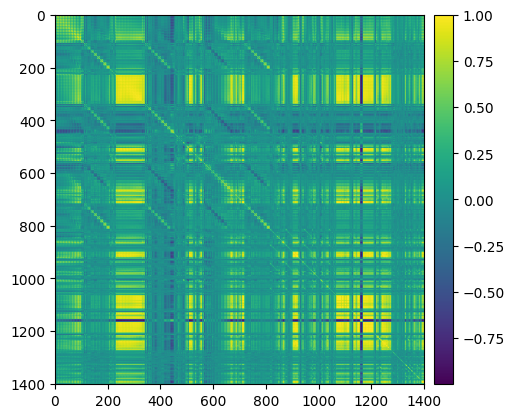

In [38]:
plt.figure()
ax = plt.gca()
im = ax.imshow(corr_df/corr_df.stack().max())
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(im, cax=cax);

## Features clustering

In [40]:
def convert_to_distance(corr_df, corr_measure):
    # convert correlation measure to distance metric
    if corr_measure in ['pearson', 'spearman']:
        distance_matrix = 1 - corr_df.abs()
    elif corr_measure == 'mutual_info':
        distance_matrix = 1/corr_df # to fix
    else:
        raise NotImplementedError('TODO')
    return distance_matrix

In [41]:
distance_matrix = convert_to_distance(corr_df, corr_measure)

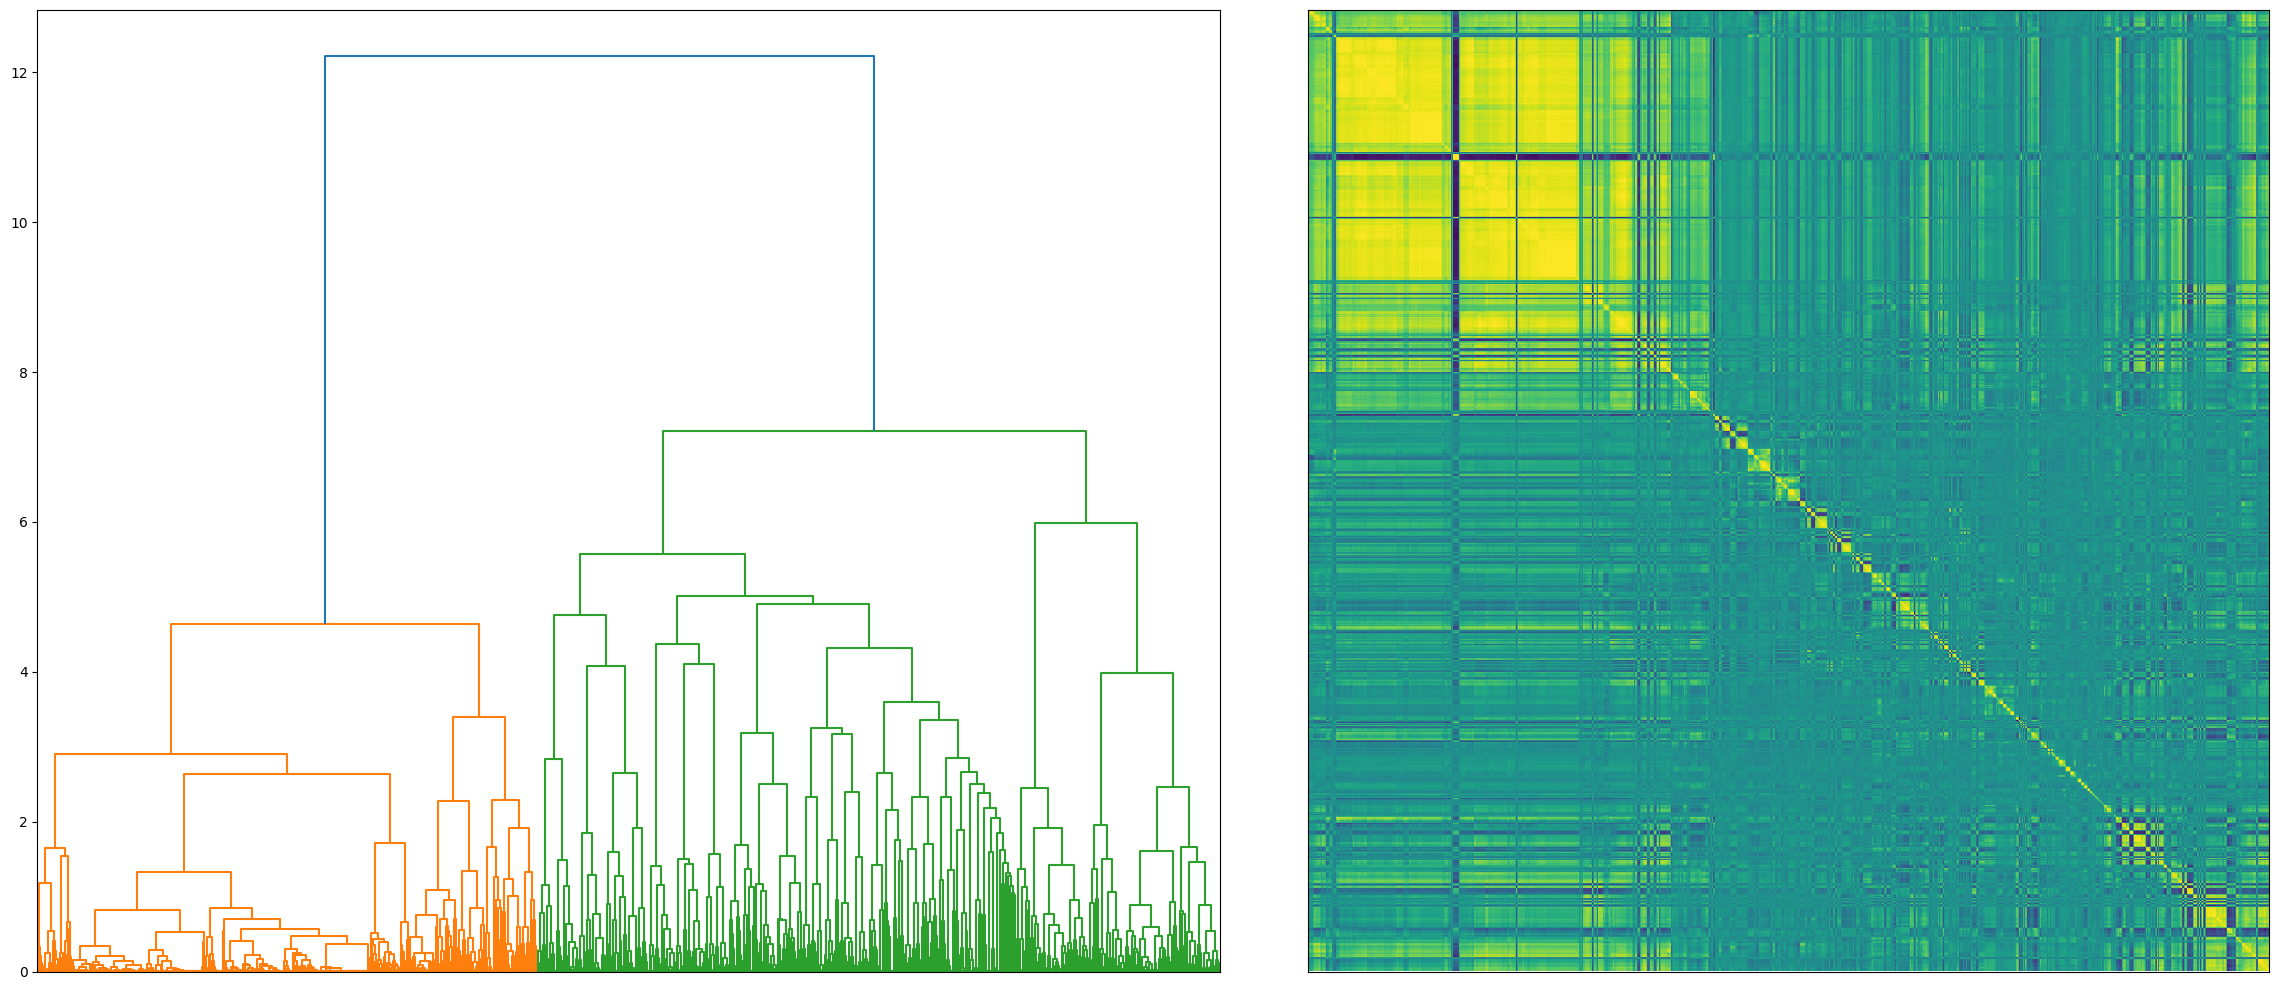

In [42]:
dist_linkage = hierarchy.ward(squareform(distance_matrix))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 10))

dendro = hierarchy.dendrogram(dist_linkage, labels=features, ax=ax1, leaf_rotation=90)
ax1.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

dendro_idx = np.arange(0, len(dendro["ivl"]))
ax2.imshow(corr_df.values[dendro["leaves"], :][:, dendro["leaves"]])
ax2.tick_params(
    axis='both',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    left=False,
    labelleft=False,
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
fig.tight_layout()
plt.show()

## Feature selection

In [13]:
comb = df.loc[rows, features + [target]].copy()
comb.reset_index(drop=True, inplace=True)

In [14]:
ks_df = pd.DataFrame(index=features, columns=['ks'], data=0.0)

for col in tqdm(features):
    ks_df.loc[col, 'ks'] = mutual_info_classif(comb[col].fillna(comb[col].mean()).values.reshape(-1, 1), comb[target].values)

  0%|          | 0/1402 [00:00<?, ?it/s]

In [15]:
ks_df.sort_values(by='ks', ascending=False).iloc[:20]

,ks
BCUTv-1l,0.301482
BCUTi-1h,0.291164
MinPartialCharge,0.282542
MaxAbsPartialCharge,0.276719
TopoPSA,0.274208
MinAbsPartialCharge,0.264140
TPSA.1,0.262946
BCUTm-1h,0.261992
MaxPartialCharge,0.261659
TPSA.2,0.261597


In [16]:
### compute thresholds

clusters_number_dict = {}
clusters_number_dict[np.inf] = 1
clusters_number_tmp = 0
clusters_number_old = 0

for th in np.linspace(-0.1, 10, 1000)[::-1]:
    cluster_ids = hierarchy.fcluster(dist_linkage, th, criterion="distance")
    clusters_number_tmp = len(np.unique(cluster_ids))
    if clusters_number_tmp > clusters_number_old:
        clusters_number_dict[th] = clusters_number_tmp
        clusters_number_old = clusters_number_tmp

In [17]:
train = comb.copy()
train[target].replace({'Bitter': 0, 'Sweet': 1}, inplace=True)
custom_cv = create_folds(train=train, features=features, target=target, num_folds=NUM_FOLDS, shuffle=True, seed=SEED)

In [18]:
clusters_number_dict = dict(list(clusters_number_dict.items())[:100])
clusters_number_dict

{inf: 1,
 10.0: 2,
 7.20960960960961: 3,
 5.9761761761761765: 4,
 5.571771771771773: 5,
 5.005605605605606: 6,
 4.904504504504505: 7,
 4.752852852852853: 8,
 4.631531531531532: 9,
 4.368668668668669: 10,
 4.318118118118119: 11,
 4.095695695695696: 12,
 4.065365365365366: 13,
 3.9743743743743747: 14,
 3.5901901901901905: 15,
 3.398098098098098: 16,
 3.347547547547548: 17,
 3.2464464464464466: 18,
 3.175675675675676: 19,
 3.1655655655655655: 20,
 2.902702702702703: 21,
 2.842042042042042: 22,
 2.831931931931932: 23,
 2.64994994994995: 24,
 2.6398398398398397: 26,
 2.6297297297297297: 27,
 2.498298298298298: 29,
 2.467967967967968: 30,
 2.447747747747748: 31,
 2.387087087087087: 32,
 2.376976976976977: 33,
 2.3264264264264263: 35,
 2.3163163163163163: 36,
 2.275875875875876: 37,
 2.265765765765766: 38,
 2.1747747747747748: 39,
 2.1545545545545544: 40,
 2.043343343343343: 41,
 1.9523523523523525: 42,
 1.9119119119119121: 44,
 1.9018018018018017: 45,
 1.8815815815815815: 46,
 1.841141141141

In [19]:
results_df = pd.DataFrame(index=range(len(clusters_number_dict)), columns=['th', 'clusters_number', 'auc_mean', 'auc_std', 'mean_abs_correlation'])

for i, (th, clusters_number) in tqdm(enumerate(clusters_number_dict.items()), total=len(clusters_number_dict)):
    selected_features = []
    if th == np.inf:
        selected_features.append(ks_df.sort_values('ks', ascending=False).head(1).index[0])
        results_tmp = evaluate(params=PARAMS_GB, train=train, features=selected_features, target=target, folds=custom_cv, return_res=True)
        results_df.loc[i, 'th'] = th
        results_df.loc[i, 'clusters_number'] = clusters_number
        results_df.loc[i, 'auc_mean'] = results_tmp.valid_auc.mean()
        results_df.loc[i, 'auc_std'] = results_tmp.valid_auc.std(ddof=0)
        results_df.loc[i, 'mean_abs_correlation'] = corr_df.abs().stack().mean()
    else:
        cluster_ids = hierarchy.fcluster(dist_linkage, th, criterion="distance")
        assert(clusters_number == len(np.unique(cluster_ids)))
        
        cluster_id_to_feature = defaultdict(list)
        for idx, cluster_id in enumerate(cluster_ids):
            cluster_id_to_feature[cluster_id].append(features[idx])
        
        mean_abs_correlation = 0  
        for cluster_id, cluster_features in cluster_id_to_feature.items():
            corr_df_tmp = corr_df.loc[cluster_features, cluster_features].copy()
            mean_abs_correlation += corr_df_tmp.abs().stack().mean() / len(cluster_id_to_feature)
            selected_features.append(ks_df.loc[cluster_id_to_feature[cluster_id], 'ks'].idxmax())
        
        results_tmp = evaluate(params=PARAMS_GB, train=train, features=selected_features, target=target, folds=custom_cv, return_res=True)
        results_df.loc[i, 'th'] = th
        results_df.loc[i, 'clusters_number'] = clusters_number
        results_df.loc[i, 'auc_mean'] = results_tmp.valid_auc.mean()
        results_df.loc[i, 'auc_std'] = results_tmp.valid_auc.std(ddof=0)
        results_df.loc[i, 'mean_abs_correlation'] = mean_abs_correlation

  0%|          | 0/100 [00:00<?, ?it/s]

C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.85422
Fold 2 AUC: 0.83506
Fold 3 AUC: 0.82253
Fold 4 AUC: 0.83704
Fold 5 AUC: 0.82387
Folds AUC: 0.83454+-0.01142
Total AUC: 0.83365


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.89358
Fold 2 AUC: 0.84803
Fold 3 AUC: 0.86172
Fold 4 AUC: 0.88107
Fold 5 AUC: 0.86973
Folds AUC: 0.87083+-0.01566
Total AUC: 0.87023


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.91125
Fold 2 AUC: 0.91059
Fold 3 AUC: 0.89053
Fold 4 AUC: 0.91954
Fold 5 AUC: 0.90191
Folds AUC: 0.90677+-0.00985
Total AUC: 0.90643


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.90992
Fold 2 AUC: 0.89988
Fold 3 AUC: 0.89423
Fold 4 AUC: 0.92029
Fold 5 AUC: 0.90499
Folds AUC: 0.90586+-0.00891
Total AUC: 0.90549


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[172]	cv_agg's train auc: 0.999798 + 3.19583e-05	cv_agg's valid auc: 0.910402 + 0.00460135
Fold 1 AUC: 0.91787
Fold 2 AUC: 0.90754
Fold 3 AUC: 0.90743
Fold 4 AUC: 0.91356
Fold 5 AUC: 0.90561
Folds AUC: 0.91040+-0.00460
Total AUC: 0.90954


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.91075
Fold 2 AUC: 0.91387
Fold 3 AUC: 0.90560
Fold 4 AUC: 0.91533
Fold 5 AUC: 0.90445
Folds AUC: 0.91000+-0.00434
Total AUC: 0.90961


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.92413
Fold 2 AUC: 0.92107
Fold 3 AUC: 0.91629
Fold 4 AUC: 0.92887
Fold 5 AUC: 0.91670
Folds AUC: 0.92141+-0.00472
Total AUC: 0.92094


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.93221
Fold 2 AUC: 0.91991
Fold 3 AUC: 0.92199
Fold 4 AUC: 0.92727
Fold 5 AUC: 0.91698
Folds AUC: 0.92367+-0.00544
Total AUC: 0.92358


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.92813
Fold 2 AUC: 0.92054
Fold 3 AUC: 0.93083
Fold 4 AUC: 0.93237
Fold 5 AUC: 0.92767
Folds AUC: 0.92791+-0.00407
Total AUC: 0.92739


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.93144
Fold 2 AUC: 0.92928
Fold 3 AUC: 0.92969
Fold 4 AUC: 0.93139
Fold 5 AUC: 0.93206
Folds AUC: 0.93077+-0.00109
Total AUC: 0.92987


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.93600
Fold 2 AUC: 0.92950
Fold 3 AUC: 0.93183
Fold 4 AUC: 0.93607
Fold 5 AUC: 0.92796
Folds AUC: 0.93227+-0.00331
Total AUC: 0.93182


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.93658
Fold 2 AUC: 0.93350
Fold 3 AUC: 0.93016
Fold 4 AUC: 0.93489
Fold 5 AUC: 0.92871
Folds AUC: 0.93277+-0.00293
Total AUC: 0.93196


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.93498
Fold 2 AUC: 0.93477
Fold 3 AUC: 0.93256
Fold 4 AUC: 0.93353
Fold 5 AUC: 0.93526
Folds AUC: 0.93422+-0.00102
Total AUC: 0.93378


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.93908
Fold 2 AUC: 0.93625
Fold 3 AUC: 0.92796
Fold 4 AUC: 0.94161
Fold 5 AUC: 0.93564
Folds AUC: 0.93611+-0.00460
Total AUC: 0.93552


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.93998
Fold 2 AUC: 0.93577
Fold 3 AUC: 0.93262
Fold 4 AUC: 0.94444
Fold 5 AUC: 0.93306
Folds AUC: 0.93717+-0.00448
Total AUC: 0.93687


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.94081
Fold 2 AUC: 0.93306
Fold 3 AUC: 0.93443
Fold 4 AUC: 0.94968
Fold 5 AUC: 0.93824
Folds AUC: 0.93924+-0.00590
Total AUC: 0.93813


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[165]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.939639 + 0.00576293
Fold 1 AUC: 0.94418
Fold 2 AUC: 0.92965
Fold 3 AUC: 0.94142
Fold 4 AUC: 0.94570
Fold 5 AUC: 0.93724
Folds AUC: 0.93964+-0.00576
Total AUC: 0.93919


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[132]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.940055 + 0.00324832
Fold 1 AUC: 0.93989
Fold 2 AUC: 0.93652
Fold 3 AUC: 0.94092
Fold 4 AUC: 0.94568
Fold 5 AUC: 0.93726
Folds AUC: 0.94006+-0.00325
Total AUC: 0.93993


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[62]	cv_agg's train auc: 0.999853 + 5.63796e-05	cv_agg's valid auc: 0.937143 + 0.00262855
Fold 1 AUC: 0.93994
Fold 2 AUC: 0.93300
Fold 3 AUC: 0.93586
Fold 4 AUC: 0.93996
Fold 5 AUC: 0.93695
Folds AUC: 0.93714+-0.00263
Total AUC: 0.93665


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.94129
Fold 2 AUC: 0.93768
Fold 3 AUC: 0.93399
Fold 4 AUC: 0.94306
Fold 5 AUC: 0.94125
Folds AUC: 0.93945+-0.00324
Total AUC: 0.93903


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.94206
Fold 2 AUC: 0.93892
Fold 3 AUC: 0.93896
Fold 4 AUC: 0.94371
Fold 5 AUC: 0.94127
Folds AUC: 0.94098+-0.00184
Total AUC: 0.94062


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[96]	cv_agg's train auc: 0.999998 + 1.38851e-06	cv_agg's valid auc: 0.940826 + 0.00225638
Fold 1 AUC: 0.94289
Fold 2 AUC: 0.93991
Fold 3 AUC: 0.94025
Fold 4 AUC: 0.94369
Fold 5 AUC: 0.93738
Folds AUC: 0.94083+-0.00226
Total AUC: 0.94046


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.93941
Fold 2 AUC: 0.94193
Fold 3 AUC: 0.93799
Fold 4 AUC: 0.94444
Fold 5 AUC: 0.93514
Folds AUC: 0.93978+-0.00320
Total AUC: 0.93956


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.93796
Fold 2 AUC: 0.94269
Fold 3 AUC: 0.93894
Fold 4 AUC: 0.94412
Fold 5 AUC: 0.94017
Folds AUC: 0.94078+-0.00230
Total AUC: 0.94029


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[95]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.941005 + 0.0040083
Fold 1 AUC: 0.94066
Fold 2 AUC: 0.94466
Fold 3 AUC: 0.93341
Fold 4 AUC: 0.94321
Fold 5 AUC: 0.94308
Folds AUC: 0.94100+-0.00401
Total AUC: 0.94066


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.94589
Fold 2 AUC: 0.94700
Fold 3 AUC: 0.93048
Fold 4 AUC: 0.94354
Fold 5 AUC: 0.93978
Folds AUC: 0.94134+-0.00597
Total AUC: 0.94085


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.94628
Fold 2 AUC: 0.94330
Fold 3 AUC: 0.93807
Fold 4 AUC: 0.94435
Fold 5 AUC: 0.94381
Folds AUC: 0.94316+-0.00274
Total AUC: 0.94258


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[144]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.941978 + 0.00274923
Fold 1 AUC: 0.94391
Fold 2 AUC: 0.94302
Fold 3 AUC: 0.93665
Fold 4 AUC: 0.94412
Fold 5 AUC: 0.94219
Folds AUC: 0.94198+-0.00275
Total AUC: 0.94149


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[109]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.94336 + 0.0028653
Fold 1 AUC: 0.94320
Fold 2 AUC: 0.94699
Fold 3 AUC: 0.93840
Fold 4 AUC: 0.94514
Fold 5 AUC: 0.94306
Folds AUC: 0.94336+-0.00287
Total AUC: 0.94275


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[68]	cv_agg's train auc: 0.999969 + 2.23524e-05	cv_agg's valid auc: 0.939842 + 0.00474828
Fold 1 AUC: 0.94016
Fold 2 AUC: 0.94388
Fold 3 AUC: 0.93098
Fold 4 AUC: 0.94404
Fold 5 AUC: 0.94015
Folds AUC: 0.93984+-0.00475
Total AUC: 0.93958


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[83]	cv_agg's train auc: 0.999998 + 1.95499e-06	cv_agg's valid auc: 0.941051 + 0.00516023
Fold 1 AUC: 0.94143
Fold 2 AUC: 0.94703
Fold 3 AUC: 0.93208
Fold 4 AUC: 0.94493
Fold 5 AUC: 0.93978
Folds AUC: 0.94105+-0.00516
Total AUC: 0.94095


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.94200
Fold 2 AUC: 0.94697
Fold 3 AUC: 0.93362
Fold 4 AUC: 0.94404
Fold 5 AUC: 0.94406
Folds AUC: 0.94214+-0.00454
Total AUC: 0.94185


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[131]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.943481 + 0.00348919
Fold 1 AUC: 0.94472
Fold 2 AUC: 0.94830
Fold 3 AUC: 0.93772
Fold 4 AUC: 0.94452
Fold 5 AUC: 0.94215
Folds AUC: 0.94348+-0.00349
Total AUC: 0.94276


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[125]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.943377 + 0.00639193
Fold 1 AUC: 0.95072
Fold 2 AUC: 0.94597
Fold 3 AUC: 0.93150
Fold 4 AUC: 0.94491
Fold 5 AUC: 0.94379
Folds AUC: 0.94338+-0.00639
Total AUC: 0.94289


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95199
Fold 2 AUC: 0.94628
Fold 3 AUC: 0.93216
Fold 4 AUC: 0.94697
Fold 5 AUC: 0.94468
Folds AUC: 0.94442+-0.00660
Total AUC: 0.94381


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[138]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.944268 + 0.00623652
Fold 1 AUC: 0.95190
Fold 2 AUC: 0.94466
Fold 3 AUC: 0.93293
Fold 4 AUC: 0.94693
Fold 5 AUC: 0.94491
Folds AUC: 0.94427+-0.00624
Total AUC: 0.94337


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[138]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.944268 + 0.00623652
Fold 1 AUC: 0.95190
Fold 2 AUC: 0.94466
Fold 3 AUC: 0.93293
Fold 4 AUC: 0.94693
Fold 5 AUC: 0.94491
Folds AUC: 0.94427+-0.00624
Total AUC: 0.94337


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.94878
Fold 2 AUC: 0.94628
Fold 3 AUC: 0.93202
Fold 4 AUC: 0.94577
Fold 5 AUC: 0.94662
Folds AUC: 0.94389+-0.00603
Total AUC: 0.94320


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[117]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.942578 + 0.00713261
Fold 1 AUC: 0.95140
Fold 2 AUC: 0.94558
Fold 3 AUC: 0.92967
Fold 4 AUC: 0.94283
Fold 5 AUC: 0.94342
Folds AUC: 0.94258+-0.00713
Total AUC: 0.94203
Training until validation scores don't improve for 20 rounds


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[141]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.94572 + 0.00615731
Fold 1 AUC: 0.95457
Fold 2 AUC: 0.94691
Fold 3 AUC: 0.93651
Fold 4 AUC: 0.94882
Fold 5 AUC: 0.94179
Folds AUC: 0.94572+-0.00616
Total AUC: 0.94515


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[80]	cv_agg's train auc: 0.999998 + 1.45965e-06	cv_agg's valid auc: 0.942935 + 0.00889489
Fold 1 AUC: 0.95600
Fold 2 AUC: 0.94619
Fold 3 AUC: 0.93004
Fold 4 AUC: 0.94581
Fold 5 AUC: 0.93663
Folds AUC: 0.94293+-0.00889
Total AUC: 0.94200


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[76]	cv_agg's train auc: 0.999998 + 1.95499e-06	cv_agg's valid auc: 0.942235 + 0.00809977
Fold 1 AUC: 0.95313
Fold 2 AUC: 0.94540
Fold 3 AUC: 0.93062
Fold 4 AUC: 0.94656
Fold 5 AUC: 0.93547
Folds AUC: 0.94224+-0.00810
Total AUC: 0.94140


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[87]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.943592 + 0.00746786
Fold 1 AUC: 0.95436
Fold 2 AUC: 0.94546
Fold 3 AUC: 0.93102
Fold 4 AUC: 0.94437
Fold 5 AUC: 0.94275
Folds AUC: 0.94359+-0.00747
Total AUC: 0.94256


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95276
Fold 2 AUC: 0.94743
Fold 3 AUC: 0.93324
Fold 4 AUC: 0.94142
Fold 5 AUC: 0.93978
Folds AUC: 0.94292+-0.00668
Total AUC: 0.94239


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95419
Fold 2 AUC: 0.94853
Fold 3 AUC: 0.93611
Fold 4 AUC: 0.94839
Fold 5 AUC: 0.94629
Folds AUC: 0.94670+-0.00591
Total AUC: 0.94613


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[124]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.945649 + 0.0065568
Fold 1 AUC: 0.95238
Fold 2 AUC: 0.94980
Fold 3 AUC: 0.93335
Fold 4 AUC: 0.94618
Fold 5 AUC: 0.94654
Folds AUC: 0.94565+-0.00656
Total AUC: 0.94495


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95708
Fold 2 AUC: 0.94861
Fold 3 AUC: 0.93921
Fold 4 AUC: 0.94523
Fold 5 AUC: 0.94905
Folds AUC: 0.94784+-0.00581
Total AUC: 0.94705


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95750
Fold 2 AUC: 0.95059
Fold 3 AUC: 0.93803
Fold 4 AUC: 0.94608
Fold 5 AUC: 0.94385
Folds AUC: 0.94721+-0.00655
Total AUC: 0.94612


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95779
Fold 2 AUC: 0.94913
Fold 3 AUC: 0.92952
Fold 4 AUC: 0.95043
Fold 5 AUC: 0.94845
Folds AUC: 0.94706+-0.00939
Total AUC: 0.94626


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[73]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.946286 + 0.00707149
Fold 1 AUC: 0.95284
Fold 2 AUC: 0.95138
Fold 3 AUC: 0.93370
Fold 4 AUC: 0.95009
Fold 5 AUC: 0.94342
Folds AUC: 0.94629+-0.00707
Total AUC: 0.94568
Training until validation scores don't improve for 20 rounds


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Early stopping, best iteration is:
[93]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.947098 + 0.00762906
Fold 1 AUC: 0.95392
Fold 2 AUC: 0.95398
Fold 3 AUC: 0.93368
Fold 4 AUC: 0.94986
Fold 5 AUC: 0.94404
Folds AUC: 0.94710+-0.00763
Total AUC: 0.94675


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95253
Fold 2 AUC: 0.95251
Fold 3 AUC: 0.93387
Fold 4 AUC: 0.94887
Fold 5 AUC: 0.94208
Folds AUC: 0.94597+-0.00715
Total AUC: 0.94526


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95147
Fold 2 AUC: 0.95059
Fold 3 AUC: 0.93653
Fold 4 AUC: 0.95001
Fold 5 AUC: 0.94479
Folds AUC: 0.94668+-0.00558
Total AUC: 0.94619


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[118]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.947751 + 0.00690859
Fold 1 AUC: 0.95598
Fold 2 AUC: 0.95482
Fold 3 AUC: 0.93736
Fold 4 AUC: 0.94602
Fold 5 AUC: 0.94458
Folds AUC: 0.94775+-0.00691
Total AUC: 0.94719
Training until validation scores don't improve for 20 rounds


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 1 AUC: 0.95413
Fold 2 AUC: 0.95132
Fold 3 AUC: 0.93079
Fold 4 AUC: 0.94801
Fold 5 AUC: 0.94610
Folds AUC: 0.94607+-0.00812
Total AUC: 0.94547


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95313
Fold 2 AUC: 0.94857
Fold 3 AUC: 0.93732
Fold 4 AUC: 0.94627
Fold 5 AUC: 0.94674
Folds AUC: 0.94641+-0.00515
Total AUC: 0.94560


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95205
Fold 2 AUC: 0.95038
Fold 3 AUC: 0.93622
Fold 4 AUC: 0.94747
Fold 5 AUC: 0.94441
Folds AUC: 0.94611+-0.00559
Total AUC: 0.94570


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[112]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.946028 + 0.006502
Fold 1 AUC: 0.95094
Fold 2 AUC: 0.95045
Fold 3 AUC: 0.93401
Fold 4 AUC: 0.95051
Fold 5 AUC: 0.94423
Folds AUC: 0.94603+-0.00650
Total AUC: 0.94546


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95238
Fold 2 AUC: 0.95094
Fold 3 AUC: 0.93418
Fold 4 AUC: 0.94953
Fold 5 AUC: 0.94860
Folds AUC: 0.94713+-0.00660
Total AUC: 0.94658


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[219]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.945125 + 0.00655031
Fold 1 AUC: 0.95036
Fold 2 AUC: 0.95396
Fold 3 AUC: 0.93553
Fold 4 AUC: 0.94475
Fold 5 AUC: 0.94102
Folds AUC: 0.94513+-0.00655
Total AUC: 0.94470


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[110]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.9449 + 0.00584486
Fold 1 AUC: 0.95015
Fold 2 AUC: 0.94953
Fold 3 AUC: 0.93453
Fold 4 AUC: 0.94781
Fold 5 AUC: 0.94248
Folds AUC: 0.94490+-0.00584
Total AUC: 0.94460


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95582
Fold 2 AUC: 0.95182
Fold 3 AUC: 0.93403
Fold 4 AUC: 0.95163
Fold 5 AUC: 0.94127
Folds AUC: 0.94691+-0.00804
Total AUC: 0.94643


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[147]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.947002 + 0.00766395
Fold 1 AUC: 0.95384
Fold 2 AUC: 0.94972
Fold 3 AUC: 0.93235
Fold 4 AUC: 0.95199
Fold 5 AUC: 0.94712
Folds AUC: 0.94700+-0.00766
Total AUC: 0.94603


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[77]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.946532 + 0.00567175
Fold 1 AUC: 0.95388
Fold 2 AUC: 0.95005
Fold 3 AUC: 0.93724
Fold 4 AUC: 0.94760
Fold 5 AUC: 0.94389
Folds AUC: 0.94653+-0.00567
Total AUC: 0.94600


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95224
Fold 2 AUC: 0.94564
Fold 3 AUC: 0.93154
Fold 4 AUC: 0.94785
Fold 5 AUC: 0.94223
Folds AUC: 0.94390+-0.00698
Total AUC: 0.94300


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95111
Fold 2 AUC: 0.95253
Fold 3 AUC: 0.93274
Fold 4 AUC: 0.95184
Fold 5 AUC: 0.94215
Folds AUC: 0.94607+-0.00766
Total AUC: 0.94549


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[60]	cv_agg's train auc: 0.999993 + 6.1685e-06	cv_agg's valid auc: 0.944522 + 0.00814153
Fold 1 AUC: 0.94934
Fold 2 AUC: 0.95186
Fold 3 AUC: 0.93179
Fold 4 AUC: 0.95159
Fold 5 AUC: 0.93803
Folds AUC: 0.94452+-0.00814
Total AUC: 0.94376


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[98]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.946066 + 0.00699281
Fold 1 AUC: 0.95228
Fold 2 AUC: 0.95263
Fold 3 AUC: 0.93416
Fold 4 AUC: 0.94885
Fold 5 AUC: 0.94242
Folds AUC: 0.94607+-0.00699
Total AUC: 0.94508


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[86]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.946012 + 0.00832316
Fold 1 AUC: 0.95365
Fold 2 AUC: 0.95132
Fold 3 AUC: 0.93010
Fold 4 AUC: 0.94857
Fold 5 AUC: 0.94641
Folds AUC: 0.94601+-0.00832
Total AUC: 0.94516


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[94]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.947065 + 0.00849136
Fold 1 AUC: 0.95430
Fold 2 AUC: 0.95361
Fold 3 AUC: 0.93310
Fold 4 AUC: 0.95309
Fold 5 AUC: 0.94123
Folds AUC: 0.94706+-0.00849
Total AUC: 0.94639


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[94]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.947065 + 0.00849136
Fold 1 AUC: 0.95430
Fold 2 AUC: 0.95361
Fold 3 AUC: 0.93310
Fold 4 AUC: 0.95309
Fold 5 AUC: 0.94123
Folds AUC: 0.94706+-0.00849
Total AUC: 0.94639


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95161
Fold 2 AUC: 0.95051
Fold 3 AUC: 0.93657
Fold 4 AUC: 0.94874
Fold 5 AUC: 0.94404
Folds AUC: 0.94629+-0.00551
Total AUC: 0.94564


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95040
Fold 2 AUC: 0.94972
Fold 3 AUC: 0.93524
Fold 4 AUC: 0.95180
Fold 5 AUC: 0.94410
Folds AUC: 0.94625+-0.00610
Total AUC: 0.94551


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[167]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.946365 + 0.00663303
Fold 1 AUC: 0.95005
Fold 2 AUC: 0.94789
Fold 3 AUC: 0.93343
Fold 4 AUC: 0.95209
Fold 5 AUC: 0.94837
Folds AUC: 0.94636+-0.00663
Total AUC: 0.94587


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95005
Fold 2 AUC: 0.94789
Fold 3 AUC: 0.93343
Fold 4 AUC: 0.95209
Fold 5 AUC: 0.94837
Folds AUC: 0.94636+-0.00663
Total AUC: 0.94587


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95005
Fold 2 AUC: 0.94789
Fold 3 AUC: 0.93343
Fold 4 AUC: 0.95209
Fold 5 AUC: 0.94837
Folds AUC: 0.94636+-0.00663
Total AUC: 0.94587


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95492
Fold 2 AUC: 0.94936
Fold 3 AUC: 0.93649
Fold 4 AUC: 0.94976
Fold 5 AUC: 0.94597
Folds AUC: 0.94730+-0.00612
Total AUC: 0.94687


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[96]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.946273 + 0.00690404
Fold 1 AUC: 0.95263
Fold 2 AUC: 0.94876
Fold 3 AUC: 0.93289
Fold 4 AUC: 0.94962
Fold 5 AUC: 0.94747
Folds AUC: 0.94627+-0.00690
Total AUC: 0.94574


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[106]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.947464 + 0.00550553
Fold 1 AUC: 0.95405
Fold 2 AUC: 0.95080
Fold 3 AUC: 0.93809
Fold 4 AUC: 0.94932
Fold 5 AUC: 0.94506
Folds AUC: 0.94746+-0.00551
Total AUC: 0.94672


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95727
Fold 2 AUC: 0.95124
Fold 3 AUC: 0.93468
Fold 4 AUC: 0.94928
Fold 5 AUC: 0.94446
Folds AUC: 0.94739+-0.00757
Total AUC: 0.94680


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95378
Fold 2 AUC: 0.94772
Fold 3 AUC: 0.93439
Fold 4 AUC: 0.94893
Fold 5 AUC: 0.94416
Folds AUC: 0.94580+-0.00648
Total AUC: 0.94526


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[108]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.94669 + 0.00628993
Fold 1 AUC: 0.95477
Fold 2 AUC: 0.95045
Fold 3 AUC: 0.93626
Fold 4 AUC: 0.94805
Fold 5 AUC: 0.94392
Folds AUC: 0.94669+-0.00629
Total AUC: 0.94615


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[132]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.947177 + 0.00680008
Fold 1 AUC: 0.95455
Fold 2 AUC: 0.95346
Fold 3 AUC: 0.93584
Fold 4 AUC: 0.94778
Fold 5 AUC: 0.94425
Folds AUC: 0.94718+-0.00680
Total AUC: 0.94662


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95388
Fold 2 AUC: 0.95122
Fold 3 AUC: 0.93720
Fold 4 AUC: 0.95143
Fold 5 AUC: 0.94354
Folds AUC: 0.94745+-0.00619
Total AUC: 0.94660


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[129]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.947518 + 0.00516156
Fold 1 AUC: 0.95207
Fold 2 AUC: 0.95240
Fold 3 AUC: 0.93890
Fold 4 AUC: 0.94976
Fold 5 AUC: 0.94446
Folds AUC: 0.94752+-0.00516
Total AUC: 0.94679


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95207
Fold 2 AUC: 0.95240
Fold 3 AUC: 0.93890
Fold 4 AUC: 0.94976
Fold 5 AUC: 0.94265
Folds AUC: 0.94716+-0.00542
Total AUC: 0.94651


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95149
Fold 2 AUC: 0.95211
Fold 3 AUC: 0.93932
Fold 4 AUC: 0.94932
Fold 5 AUC: 0.94531
Folds AUC: 0.94751+-0.00474
Total AUC: 0.94688


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[84]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.946103 + 0.00626185
Fold 1 AUC: 0.94934
Fold 2 AUC: 0.95182
Fold 3 AUC: 0.93430
Fold 4 AUC: 0.94972
Fold 5 AUC: 0.94533
Folds AUC: 0.94610+-0.00626
Total AUC: 0.94549


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[167]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.947689 + 0.00566902
Fold 1 AUC: 0.95244
Fold 2 AUC: 0.95465
Fold 3 AUC: 0.93932
Fold 4 AUC: 0.94866
Fold 5 AUC: 0.94337
Folds AUC: 0.94769+-0.00567
Total AUC: 0.94690


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95403
Fold 2 AUC: 0.95315
Fold 3 AUC: 0.93917
Fold 4 AUC: 0.94735
Fold 5 AUC: 0.94167
Folds AUC: 0.94707+-0.00595
Total AUC: 0.94648


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.94789
Fold 2 AUC: 0.94976
Fold 3 AUC: 0.93709
Fold 4 AUC: 0.94964
Fold 5 AUC: 0.94500
Folds AUC: 0.94587+-0.00472
Total AUC: 0.94552


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[100]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.94736 + 0.0051965
Fold 1 AUC: 0.95242
Fold 2 AUC: 0.95047
Fold 3 AUC: 0.93799
Fold 4 AUC: 0.95032
Fold 5 AUC: 0.94560
Folds AUC: 0.94736+-0.00520
Total AUC: 0.94673


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[79]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.946827 + 0.00557279
Fold 1 AUC: 0.94845
Fold 2 AUC: 0.95224
Fold 3 AUC: 0.93759
Fold 4 AUC: 0.95215
Fold 5 AUC: 0.94371
Folds AUC: 0.94683+-0.00557
Total AUC: 0.94626


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95282
Fold 2 AUC: 0.94712
Fold 3 AUC: 0.93580
Fold 4 AUC: 0.95022
Fold 5 AUC: 0.94475
Folds AUC: 0.94614+-0.00585
Total AUC: 0.94578


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95138
Fold 2 AUC: 0.94782
Fold 3 AUC: 0.93318
Fold 4 AUC: 0.95249
Fold 5 AUC: 0.94202
Folds AUC: 0.94538+-0.00711
Total AUC: 0.94520


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95452
Fold 2 AUC: 0.94726
Fold 3 AUC: 0.94000
Fold 4 AUC: 0.95205
Fold 5 AUC: 0.94572
Folds AUC: 0.94791+-0.00507
Total AUC: 0.94710


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[92]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.946748 + 0.00656491
Fold 1 AUC: 0.95144
Fold 2 AUC: 0.95292
Fold 3 AUC: 0.93684
Fold 4 AUC: 0.95159
Fold 5 AUC: 0.94094
Folds AUC: 0.94675+-0.00656
Total AUC: 0.94628


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[128]	cv_agg's train auc: 0.999999 + 1.088e-06	cv_agg's valid auc: 0.947771 + 0.00594571
Fold 1 AUC: 0.95082
Fold 2 AUC: 0.95113
Fold 3 AUC: 0.93957
Fold 4 AUC: 0.95527
Fold 5 AUC: 0.94206
Folds AUC: 0.94777+-0.00595
Total AUC: 0.94713


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.94793
Fold 2 AUC: 0.95070
Fold 3 AUC: 0.93503
Fold 4 AUC: 0.95095
Fold 5 AUC: 0.94254
Folds AUC: 0.94543+-0.00601
Total AUC: 0.94500


C:\Users\gabriele.maroni\.conda\envs\VirtuousSweetBitter\lib\site-packages\lightgbm\engine.py:573: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 20 rounds
Fold 1 AUC: 0.95251
Fold 2 AUC: 0.94820
Fold 3 AUC: 0.94061
Fold 4 AUC: 0.95163
Fold 5 AUC: 0.94396
Folds AUC: 0.94738+-0.00453
Total AUC: 0.94690


In [20]:
clustering_results = {'correlation_matrix': corr_df, 'distance_linkage': dist_linkage, 'Kolmogorov_Smirnov': ks_df, 'thresholds': clusters_number_dict, 'results': results_df}
correlation_matrix, distance_linkage, kolmogorov_smirnov, thresholds, results = clustering_results.values()

In [21]:
ZOOM = (0,50)

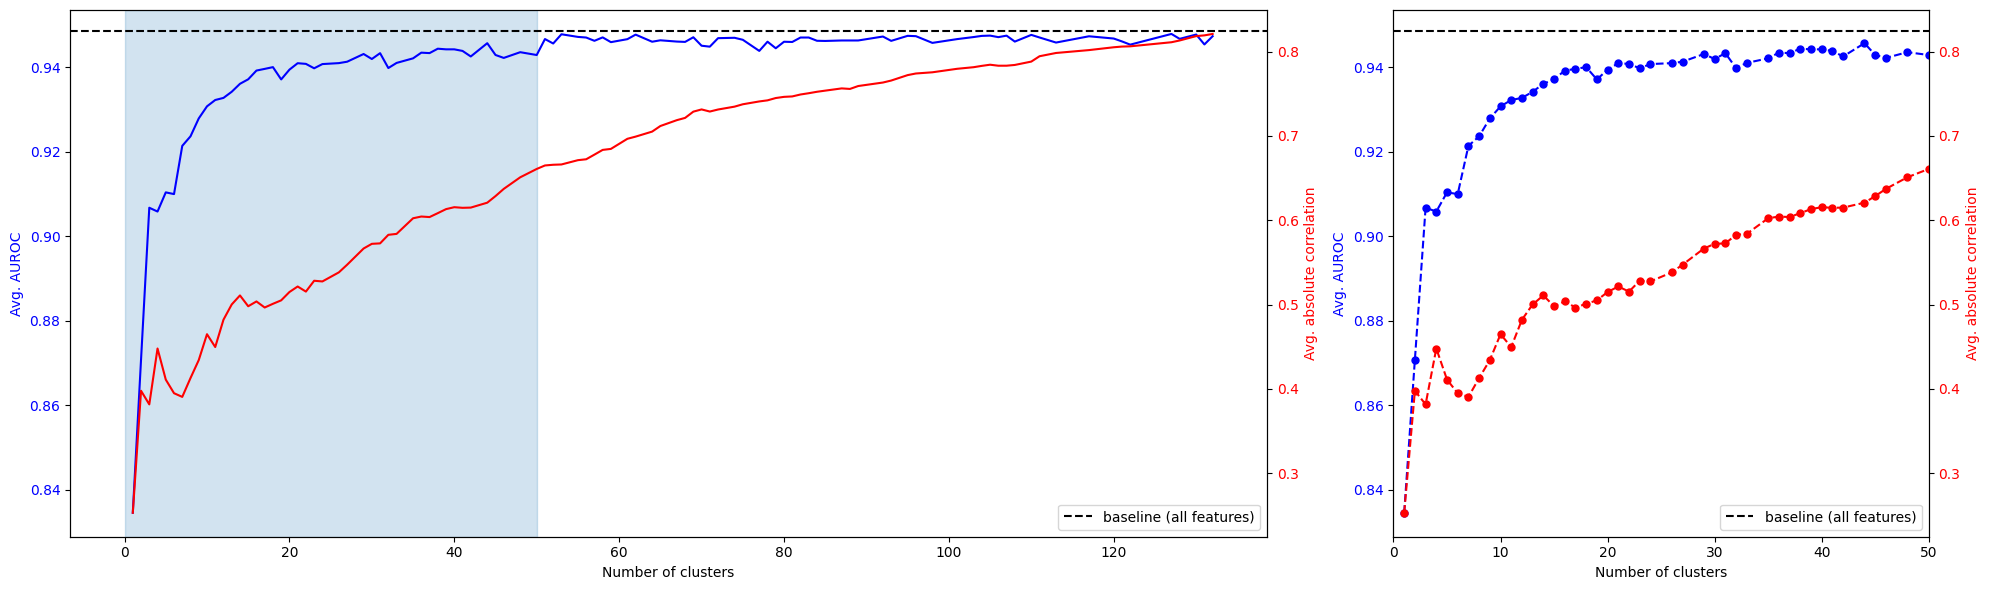

In [22]:
fig = plt.figure(figsize=(20, 6))

ax0 = fig.add_subplot(1,3,(1,2))
results.set_index('clusters_number').auc_mean.plot(ax=ax0, label='', color='blue')
ax0.axhline(0.94862, linestyle='--', color='k', label='baseline (all features)')
ax0.axvspan(ZOOM[0], ZOOM[1], alpha=0.2, color='tab:blue')
ax0.tick_params(axis='y', labelcolor='blue')
ax0.set_xlabel('Number of clusters')
ax0.set_ylabel('Avg. AUROC', color='blue')
ax02 = ax0.twinx()
results.set_index('clusters_number').mean_abs_correlation.plot(ax=ax02, label='', color='red')
ax02.tick_params(axis='y', labelcolor='red')
ax02.set_ylabel('Avg. absolute correlation', color='red')
ax02.grid(False)
ax0.legend()

ax1 = fig.add_subplot(1,3,3)
results.set_index('clusters_number').auc_mean.plot(ax=ax1, label='', linestyle='--', marker='.', markersize=10, color='blue')
ax1.axhline(0.94862, linestyle='--', color='k', label='baseline (all features)')
ax1.set_xlim(ZOOM[0], ZOOM[1])
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xlabel('Number of clusters')
ax1.set_ylabel('Avg. AUROC', color='blue')
ax12 = ax1.twinx()
results.set_index('clusters_number').mean_abs_correlation.plot(ax=ax12, label='', linestyle='--', marker='.', markersize=10, color='red')
ax12.tick_params(axis='y', labelcolor='red')
ax12.set_ylabel('Avg. absolute correlation', color='red')
ax12.grid(False)
ax1.legend()

plt.tight_layout()

In [23]:
CLUSTERS_NUMBER = 30

auc = results[results.clusters_number == CLUSTERS_NUMBER]['auc_mean'].values[0]
corr = results[results.clusters_number == CLUSTERS_NUMBER]['mean_abs_correlation'].values[0]
print(f'AUC with selected value of clusters number: {auc:.3f}')
print(f'Average correlation with selected value of clusters number: {corr:.2f}')

AUC with selected value of clusters number: 0.942
Average correlation with selected value of clusters number: 0.57


In [24]:
threshold = list(thresholds.keys())[list(thresholds.values()).index(CLUSTERS_NUMBER)]
cluster_ids = hierarchy.fcluster(distance_linkage, threshold, criterion='distance')
selected_features = []
        
cluster_id_to_feature = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature[cluster_id].append(features[idx])
         
for cluster_id, cluster_features in cluster_id_to_feature.items():
    selected_features.append(kolmogorov_smirnov.loc[cluster_id_to_feature[cluster_id], 'ks'].idxmax())
#selected_features.remove('fr_epoxide')

In [25]:
selected_features

['BCUTm-1h',
 'AATS0are',
 'BCUTd-1h',
 'MinPartialCharge',
 'Kier2',
 'ATSC6d',
 'AATSC8d',
 'AATSC1Z',
 'ATSC1i',
 'AETA_eta_BR',
 'AATSC2se',
 'MATS2d',
 'ATSC3m',
 'ATSC4c',
 'ATSC5c',
 'ATSC5d',
 'ATSC6pe',
 'ATSC7c',
 'ATS0m',
 'BCUTi-1h',
 'fr_Ndealkylation1',
 'TopoPSA',
 'SIC0',
 'BCUTs-1l',
 'BCUTv-1l',
 'BCUTdv-1l',
 'SsssN',
 'naHRing',
 'MAXddsN',
 'SRW03']

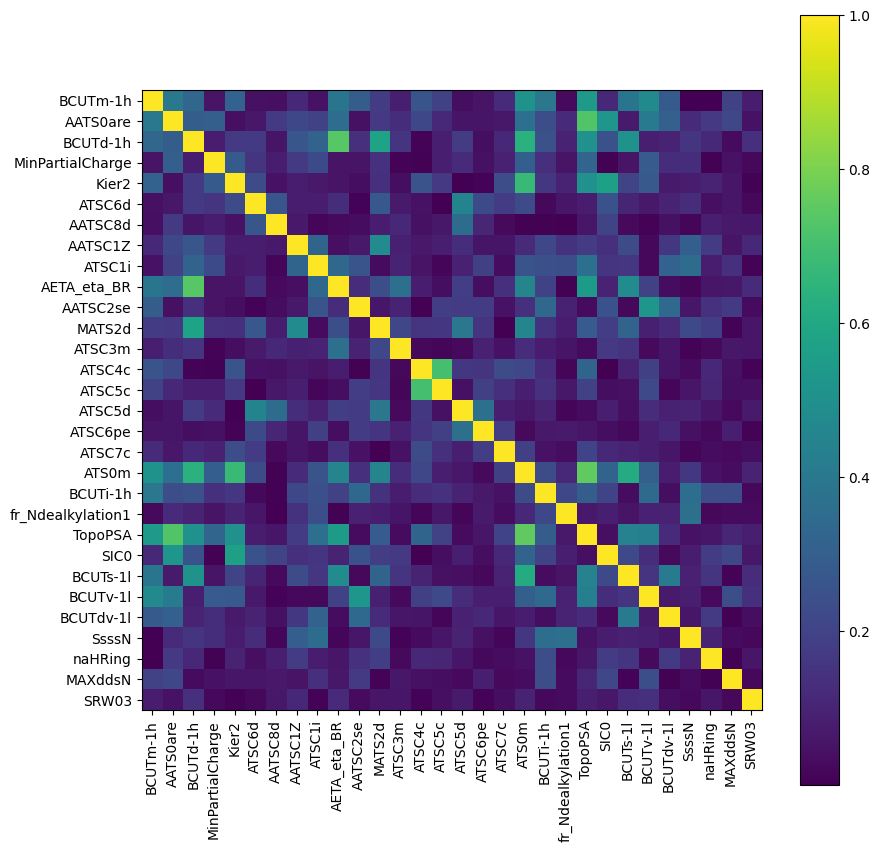

In [26]:
#mlp.rcParams['axes.grid'] = False
plt.figure(figsize=(10,10))
im = plt.imshow(correlation_matrix.loc[selected_features, selected_features].abs())
im.axes.set_xticks(np.arange(len(selected_features)))
im.axes.set_xticklabels(selected_features, rotation=90)
im.axes.set_yticks(np.arange(len(selected_features)))
im.axes.set_yticklabels(selected_features, rotation=0)
cbar = plt.colorbar(im);